In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mimg
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.datasets import cifar10


# Load MNIST dataset

In [ ]:
mnist = fetch_openml('mnist_784', cache=False)

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

x_train = X_train.to_numpy()[:2000] / 255
x_test = X_test.to_numpy()[:1000] / 255
y_train = y_train[:2000]
y_test = y_test[:1000]


In [3]:
class HST_KMeans:

  '''
    constructor:
      @param n_clusters: The number of clusters that you want to divide your data points into
      @param iters_per_loss: Check value of loss funtion after every iters_per_loss iterations
          default value is 1
      @param show_progress: Display loss, it depend on iters_per_loss
  '''
  def __init__(self, n_clusters=0, iters_per_loss=1, show_progress=False):
    if n_clusters <= 0 or not isinstance(n_clusters, int):
      raise ValueError('number of clusters must be a positive integer!')
    self.reset_state()
    self.n_clusters = n_clusters
    self.__max_iter_ = 100000
    self.show_progress_ = show_progress
    self.iters_per_loss = iters_per_loss
  
  def __init_centers(self, X, k):
    return X[np.random.choice(X.shape[0], k, replace = False)]

  def __assign_labels(self, X, centers):
    D = cdist(X, centers)
    return np.argmin(D, axis = 1)

  def __update_centers(self, X, labels, K):
    centers = np.zeros((K, X.shape[1]))

    for k in range(K):
      Xk = X[labels == k, :]
      if Xk.shape[0] > 0:
        centers[k, :] = np.mean(Xk, axis = 0)

    return centers
  
  def __loss(self, X):
    loss = 0
    for k in range(self.n_clusters):
      lk = np.where(self.labels_ == k)[0]
      tx = cdist(X[lk, :], [self.centers_[k]])
      loss += np.sum(tx * tx)
    return loss

  def __has_converged(self, centers, new_centers):
    return (set([tuple(a) for a in centers]) == 
        set([tuple(a) for a in new_centers]))
    
  def reset_state(self):
    self.centers_ = None
    self.n_iter_ = None
    self.labels_ = None
    self.loss_ = list()
    
  def fit(self, X):
    if self.n_clusters <= 0 or not isinstance(self.n_clusters, int):
      raise ValueError('number of clusters must be a positive integer!')
    centers = self.__init_centers(X, self.n_clusters)
    self.n_iter_ = 0

    while self.n_iter_ <= self.__max_iter_:
      labels = self.__assign_labels(X, centers)
      new_centers = self.__update_centers(X, labels, self.n_clusters)
      self.labels_ = labels
      self.centers_ = new_centers
      if self.n_iter_ % self.iters_per_loss == 0:
        loss = self.__loss(X)
        self.loss_.append(loss)
        if self.show_progress_:
          print('- {iter:5d} iterations,\tloss: {loss:-15.10f}, \tcenters updated'.format(iter = self.n_iter_, loss = loss))

      self.n_iter_ += 1
      
      if self.__has_converged(centers, new_centers):
        break
      centers = new_centers
      
    else:
      print("No solution!")

    return self

  def predict(self, X):
    if self.n_clusters <= 0 or not isinstance(self.n_clusters, int):
      raise ValueError('number of clusters must be a positive integer!')
    D = cdist(X, self.centers_)
    return np.argmin(D, axis = 1)



# Train

In [ ]:
my_kmeans = HST_KMeans(n_clusters=10, show_progress=False).fit(x_test)

sk_kmeans = KMeans(n_clusters=10).fit(x_test)

my_pred_label = my_kmeans.predict(x_test)
sk_pred_label = sk_kmeans.predict(x_test)
print(f'sklearn\'s score: {accuracy_score(sk_pred_label, y_test) * 100} %')
print(f'my kmeans\'s score: {accuracy_score(my_pred_label, y_test) * 100} %')

sklearn's score: 12.2 %
my kmeans's score: 13.0 %


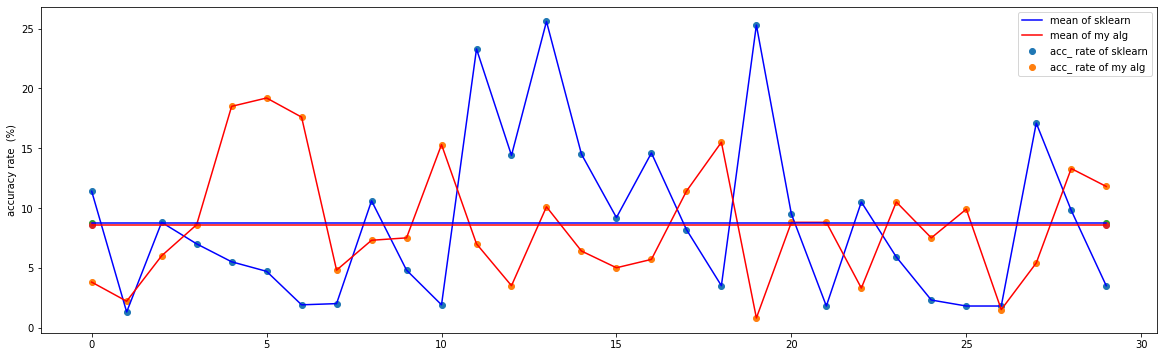

In [ ]:
def remark(n=5):
  plt.figure(figsize=(20, 6))
  skkmn = []
  mykmn = []
  for _ in range(n):
    my_kmeans = HST_KMeans(n_clusters=10, show_progress=False).fit(x_test)

    sk_kmeans = KMeans(n_clusters=10).fit(x_test)

    my_pred_label = my_kmeans.predict(x_test)
    sk_pred_label = sk_kmeans.predict(x_test)
    skkmn.append(accuracy_score(sk_pred_label, y_test) * 100)
    mykmn.append(accuracy_score(my_pred_label, y_test) * 100)
  
  skkmn = np.array(skkmn)
  mykmn = np.array(mykmn)

  plt.scatter(np.arange(n), skkmn, label='acc_ rate of sklearn')
  plt.scatter(np.arange(n), mykmn, label='acc_ rate of my alg')

  plt.plot(skkmn, 'b')
  plt.plot(mykmn, 'r')

  mean_sk = [np.mean(skkmn)] * 2
  mean_my = [np.mean(mykmn)] * 2

  plt.plot([0, n - 1], mean_sk, 'b', label='mean of sklearn')
  plt.plot([0, n - 1], mean_my, 'r', label='mean of my alg')
  plt.scatter([0, n - 1], mean_sk)
  plt.scatter([0, n - 1], mean_my)

  plt.ylabel('accuracy rate  (%)')

  plt.legend()

  plt.show()

remark(30)

# CIFAR-10 dataset

In [14]:
(x_tr, y_tr), (x_ts, y_ts) = cifar10.load_data()

# get the first 2000 train data and 200 test data
x_tr = x_tr[:5000] / 255.0
y_tr = y_tr[:5000].ravel()
x_ts = x_ts[:200] / 255.0
y_ts = y_ts[:200].ravel()

In [15]:
# Feature engineering
x_tr_1 = x_tr.reshape(x_tr.shape[0], -1)
x_tr_gray = (x_tr[:,:,:,:3] @ [0.299, 0.587, 0.114]).reshape(x_tr.shape[0], -1)

In [16]:
my_kmns = HST_KMeans(n_clusters=10, show_progress=False).fit(x_tr_1)

sk_kmns = KMeans(n_clusters=10).fit(x_tr_1)

my_pred_1 = my_kmns.predict(x_tr_1)
sk_pred_1 = sk_kmns.predict(x_tr_1)
print(f'sklearn\'s score: {accuracy_score(sk_pred_1, y_tr) * 100} %')
print(f'my kmeans\'s score: {accuracy_score(my_pred_1, y_tr) * 100} %')

sklearn's score: 9.0 %
my kmeans's score: 9.62 %


In [17]:
# Applying Grayscale
my_kmns_2 = HST_KMeans(n_clusters=10, show_progress=False).fit(x_tr_gray)

sk_kmns_2 = KMeans(n_clusters=10).fit(x_tr_gray)

my_pred_2 = my_kmns_2.predict(x_tr_gray)
sk_pred_2 = sk_kmns_2.predict(x_tr_gray)
print(f'sklearn\'s score: {accuracy_score(sk_pred_2, y_tr) * 100} %')
print(f'my kmeans\'s score: {accuracy_score(my_pred_2, y_tr) * 100} %')

sklearn's score: 11.18 %
my kmeans's score: 10.059999999999999 %
